# Final Experiments - Single-label CNNText GloVe

## Utilities and Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import itertools
from collections import Counter
import numpy as np
import pickle
from operator import itemgetter
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = [5, 10]

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.svm import LinearSVC, SVC
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from fastai import text as ft
from fastai import dataloader as fd
from fastai import dataset as fs
from fastai import learner as fl
from fastai import core as fc
from fastai import metrics as fm


from skai.runner import TextRunner, Adam_lambda
from skai.mwrapper import MWrapper, SKModel
from skai.utils import multi_to_text_out, vote_pred
from skai.utils import get_classification_type, weights_init, multilabel_prediction
from skai.dataset import TokenDataset, SimpleDataset


def mapt(f, *iters):
    return tuple(map(f, *iters))

def mapl(f, *iters):
    return list(map(f, *iters))

def manually_remove_problems(data):
    """ remove problem from data if it has a certain tag"""
    final_data = {}
    remove = ['*special']
    for i in data:
        if set(data[i][1][0]).intersection(set(remove)) == set():
            if data[i][0][0] != '':
                final_data[i] = data[i]
    return final_data

def get_single_label_problems(data):
    '''returns a dict of all problems which only have one label'''
    single_label_problems = {}
    for i in data:
        if len(data[i][1][0]) == 1:
            single_label_problems[i] = data[i]
    return single_label_problems

def get_classwise_distribution(data):
    class_count = {}
    for i in data:
        for cls in data[i][1][0]:
            if cls in class_count:
                class_count[cls] +=1 
            else:
                class_count[cls] = 1
    return class_count


def get_topk_single_label_problems(data,k):
    """ get top k by frequency single label problems"""
    class_dict = get_classwise_distribution(data)
    print(class_dict)
    class_dict = dict(sorted(class_dict.items(), key=itemgetter(1), reverse=True)[:k])
    print(set(class_dict.keys()))

    topk_data = {}
    for i in data:
        if set(data[i][1][0]).intersection(set(class_dict.keys())) != set():
            topk_data[i] = data[i]
            
    return topk_data

def make_text_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][0])
    return Xtext, ytext

def make_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][2])
    return Xtext, ytext

def make_non_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(f'{data[0][3]}\n{data[0][4]}\n{data[0][5]}')
    return Xtext, ytext

def get_class_list(labels):
    return list(set(labels))

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.gcf()
    fig.set_size_inches(22, 16)
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
#     plt.title(title, fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=32)
    plt.yticks(tick_marks, classes, fontsize=32)

    print(cm.max())
    fmt = '.2f' if normalize else 'd'
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=32)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=32)
    plt.xlabel('Predicted label', fontsize=32)

/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load data

In [2]:
top5s = pickle.load(open('data/110_5single_26aug.pkl','rb'))
top10s = pickle.load(open('data/10single_26aug.pkl','rb'))

top5s, top10s = mapt(make_text_dataset, [top5s, top10s])

In [3]:
print(len(top10s[0]))

1159


In [4]:
print(top5s[0][0])

F. One Occurrence
time limit per test3 seconds
memory limit per test768 megabytes
inputstandard input
outputstandard output
You are given an array a
consisting of n
integers, and q
queries to it. i
-th query is denoted by two integers li
and ri
. For each query, you have to find any integer that occurs exactly once in the subarray of a
from index li
to index ri
(a subarray is a contiguous subsegment of an array). For example, if a=[1,1,2,3,2,4]
, then for query (li=2,ri=6)
the subarray we are interested in is [1,2,3,2,4]
, and possible answers are 1
, 3
and 4
; for query (li=1,ri=2)
the subarray we are interested in is [1,1]
, and there is no such element that occurs exactly once.
Can you answer all of the queries?
Input
The first line contains one integer n
(1≤n≤5⋅105
).
The second line contains n
integers a1,a2,…,an
(1≤ai≤5⋅105
).
The third line contains one integer q
(1≤q≤5⋅105
).
Then q
lines follow, i
-th line containing two integers li
and ri
representing i
-th query (1≤li≤ri≤n
)

## Create GloVe embeddings

In [5]:
GLOVE_PATH = '/home/aayn/Research/glove.840B.300d.txt'

def make_glove_dict(glove_path):
    glove = {}
    with open(glove_path) as gf:
        for line in gf.readlines():
            vals = line.split(' \t')
            word, vec = vals[0], np.array(vals[1:], dtype=np.float32)
            glove[word] = vec
    return glove

def make_glove_embeddings(glove_path, stoi, embed_size=300):
    embeddings = np.zeros((len(stoi), embed_size))
    with open(glove_path) as gf:
        for line in gf.readlines():
            vals = line.split(' \t')
            word = vals[0]
            idx = stoi.get(word, -1)
            if idx != -1:
                vec = np.array(vals[1:], dtype='float32')
                embeddings[idx] = vec
    return torch.from_numpy(embeddings).float()                

In [7]:
trunner = TextRunner([None], top5s[0], top5s[1], 'top5s')
stoi = trunner.alldata.tvectorizer.stoi
glove_emb = make_glove_embeddings(GLOVE_PATH, stoi)

Checkpoint reached: raw data cleaned.
multiclass classification.


## CNN Experiments

In [11]:
class CNN_GloVe(nn.Module):
    def __init__(self, embed_num, class_num, kernel_sizes=[3, 4, 5],
                 kernel_num=512, embed_dim=300):
        super().__init__()
        self.kernel_num = kernel_num
        self.embed = nn.Embedding(glove_emb.size(0), glove_emb.size(1))
        self.embed.weight = nn.Parameter(glove_emb)
        self.embed.weight.requires_grad = False
        
        convs = [nn.Conv1d(1, kernel_num, (ks, embed_dim))
                 for ks in kernel_sizes]
        self.convs = nn.ModuleList(convs)
#         self.bn1 = nn.BatchNorm1d(kernel_num)
        self.fc1 = nn.Linear(len(kernel_sizes) * kernel_num, class_num)
    
    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N, Co, W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x
    
    def forward(self, x):
        x = self.embed(x)
        x = x.unsqueeze(1)
        
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        
        out = self.fc1(x)
        return out

### 5-class

In [12]:
trunner = TextRunner([None], top5s[0], top5s[1], 'top5s')
in_dim = len(trunner.alldata.tvectorizer.itos)
Xall, yall = trunner.dataset

Checkpoint reached: raw data cleaned.
multiclass classification.


In [13]:
runs = 5
out_dim = 5

preds_txt, targs_txt = [], []

for i in range(runs):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=i+42)
    
    outer_cv.get_n_splits(Xall, yall)
    for j, (nontest_i, test_i) in enumerate(outer_cv.split(Xall, yall)):
        X_train, y_train = Xall[nontest_i], yall[nontest_i]
        X_test, y_test = Xall[test_i], yall[test_i]
        
        textcnn = MWrapper(CNN_GloVe(in_dim, out_dim),
                               f'{i}_gl_cnntext5s_{j}')
        textcnn.model.apply(weights_init)

        dl_train = fd.DataLoader(SimpleDataset(X_train, y_train),
                                 batch_size=32, num_workers=2,
                                 pad_idx=1, transpose=False)
        dl_val = fd.DataLoader(SimpleDataset(X_test, y_test),
                               batch_size=32, num_workers=2,
                               pad_idx=1, transpose=False)
        modeldata = fs.ModelData(str(textcnn.path), dl_train, dl_val)
        learner = fl.Learner.from_model_data(textcnn.model,
                                             modeldata,
                                             opt_fn=Adam_lambda())
        learner.metrics = [fm.accuracy]
        learner.fit(5e-4, 10, best_save_name='best')
        
        dl_test = fd.DataLoader(SimpleDataset(X_test, y_test),
                                batch_size=32, num_workers=2,
                                pad_idx=1, transpose=False)
        learner.load('best')
        preds, targs = learner.predict_dl(dl_test)
        preds_txt += multi_to_text_out(preds, trunner.alldata.ovectorizer)
        targs_txt += multi_to_text_out(targs, trunner.alldata.ovectorizer)
        print(accuracy_score(targs_txt, preds_txt))

epoch      trn_loss   val_loss   accuracy                  
    0      0.165654   0.158495   0.309091  
    1      0.157012   0.150595   0.418182                  
    2      0.146295   0.138403   0.472727                  
    3      0.132172   0.126664   0.509091                  
    4      0.11642    0.121466   0.545455                  
    5      0.09981    0.119235   0.563636                   
    6      0.082712   0.117185   0.654545                   
    7      0.066103   0.117283   0.636364                   
    8      0.051231   0.11896    0.654545                   
    9      0.038775   0.120863   0.6                        

0.6545454545454545


epoch      trn_loss   val_loss   accuracy                  
    0      0.170186   0.160085   0.163636  
    1      0.158883   0.152775   0.418182                  
    2      0.147715   0.141698   0.563636                  
    3      0.134098   0.132523   0.581818                  
    4      0.118774   0.128036   0.563636                  
    5      0.102138   0.125402   0.581818                  
    6      0.084936   0.124833   0.581818                   
    7      0.068157   0.125723   0.563636                   
    8      0.052883   0.12609    0.563636                   
    9      0.040018   0.12612    0.563636                   

0.6181818181818182


epoch      trn_loss   val_loss   accuracy                  
    0      0.167948   0.157726   0.181818  
    1      0.158448   0.149501   0.490909                  
    2      0.147602   0.136163   0.563636                  
    3      0.133635   0.123949   0.545455                  
    4      0.11803    0.118019   0.545455                  
    5      0.101448   0.115058   0.6                       
    6      0.084358   0.112277   0.618182                   
    7      0.067592   0.111226   0.654545                   
    8      0.052456   0.111488   0.654545                   
    9      0.039738   0.111905   0.672727                   

0.6363636363636364


epoch      trn_loss   val_loss   accuracy                  
    0      0.167998   0.15659    0.218182  
    1      0.157418   0.146509   0.436364                  
    2      0.145701   0.134094   0.454545                  
    3      0.131138   0.124408   0.490909                  
    4      0.114904   0.120129   0.527273                  
    5      0.09783    0.117965   0.527273                   
    6      0.080582   0.117531   0.527273                   
    7      0.064173   0.118803   0.545455                   
    8      0.049595   0.119791   0.6                        
    9      0.037471   0.120585   0.581818                   

0.6272727272727273


epoch      trn_loss   val_loss   accuracy                  
    0      0.166823   0.15892    0.218182  
    1      0.158277   0.150788   0.381818                  
    2      0.148055   0.138622   0.563636                  
    3      0.134275   0.126891   0.545455                  
    4      0.118968   0.121966   0.509091                  
    5      0.103113   0.118005   0.454545                  
    6      0.086641   0.116418   0.509091                   
    7      0.070333   0.117282   0.527273                   
    8      0.055274   0.118853   0.509091                   
    9      0.042262   0.119864   0.509091                   

0.6145454545454545


epoch      trn_loss   val_loss   accuracy                  
    0      0.169198   0.157712   0.2       
    1      0.15943    0.151768   0.327273                  
    2      0.149102   0.140246   0.418182                  
    3      0.135228   0.127555   0.454545                  
    4      0.119096   0.117817   0.509091                  
    5      0.102338   0.111421   0.6                       
    6      0.08532    0.107747   0.6                        
    7      0.068708   0.10787    0.618182                   
    8      0.053633   0.108288   0.6                        
    9      0.04081    0.108578   0.618182                   

0.6151515151515151


epoch      trn_loss   val_loss   accuracy                  
    0      0.166066   0.159589   0.345455  
    1      0.155686   0.153322   0.381818                  
    2      0.143839   0.142021   0.454545                  
    3      0.129206   0.13438    0.509091                  
    4      0.113729   0.126      0.6                       
    5      0.097504   0.119483   0.6                        
    6      0.0808     0.118436   0.563636                   
    7      0.064586   0.117613   0.545455                   
    8      0.04998    0.117167   0.545455                   
    9      0.037725   0.117708   0.527273                   

0.612987012987013


epoch      trn_loss   val_loss   accuracy                  
    0      0.166279   0.156735   0.363636  
    1      0.157147   0.150425   0.418182                  
    2      0.146216   0.137445   0.490909                  
    3      0.131417   0.125619   0.563636                  
    4      0.114871   0.120927   0.618182                  
    5      0.097964   0.118963   0.6                       
    6      0.080987   0.118486   0.6                        
    7      0.064703   0.118434   0.581818                   
    8      0.050083   0.117692   0.6                        
    9      0.037851   0.117033   0.6                        

0.6136363636363636


epoch      trn_loss   val_loss   accuracy                  
    0      0.166841   0.161689   0.218182  
    1      0.15759    0.154553   0.218182                  
    2      0.146836   0.141827   0.418182                  
    3      0.1326     0.132473   0.436364                  
    4      0.11678    0.129321   0.509091                  
    5      0.100386   0.125265   0.509091                  
    6      0.083668   0.121931   0.563636                   
    7      0.067512   0.122675   0.581818                   
    8      0.052798   0.123011   0.581818                   
    9      0.040197   0.124602   0.545455                   

0.6101010101010101


epoch      trn_loss   val_loss   accuracy                  
    0      0.166222   0.155078   0.418182  
    1      0.157398   0.145623   0.436364                  
    2      0.147466   0.133238   0.6                       
    3      0.13421    0.120864   0.618182                  
    4      0.118943   0.113467   0.672727                  
    5      0.102784   0.105541   0.672727                  
    6      0.086177   0.099976   0.690909                   
    7      0.069933   0.097763   0.690909                   
    8      0.055047   0.096007   0.709091                   
    9      0.042173   0.094379   0.745455                   

0.6236363636363637


epoch      trn_loss   val_loss   accuracy                  
    0      0.166306   0.156666   0.218182  
    1      0.157409   0.148179   0.454545                  
    2      0.146975   0.136909   0.563636                  
    3      0.132961   0.126604   0.563636                  
    4      0.116945   0.12304    0.6                       
    5      0.100218   0.119358   0.618182                  
    6      0.083355   0.117354   0.6                        
    7      0.067171   0.116338   0.6                        
    8      0.052541   0.116081   0.581818                   
    9      0.040068   0.116517   0.6                        

0.6231404958677685


epoch      trn_loss   val_loss   accuracy                  
    0      0.166504   0.158413   0.272727  
    1      0.158118   0.152992   0.4                       
    2      0.148444   0.143378   0.454545                  
    3      0.135546   0.132109   0.454545                  
    4      0.120363   0.123828   0.472727                  
    5      0.104282   0.119047   0.563636                  
    6      0.087784   0.11508    0.545455                   
    7      0.071459   0.112524   0.618182                   
    8      0.056295   0.110714   0.618182                   
    9      0.043059   0.110047   0.6                        

0.6227272727272727


epoch      trn_loss   val_loss   accuracy                  
    0      0.166711   0.156864   0.254545  
    1      0.157043   0.14717    0.345455                  
    2      0.145986   0.132905   0.563636                  
    3      0.132031   0.122188   0.6                       
    4      0.116715   0.115745   0.618182                  
    5      0.100478   0.10949    0.690909                  
    6      0.083813   0.105216   0.709091                   
    7      0.06755    0.104393   0.654545                   
    8      0.052791   0.103759   0.690909                   
    9      0.040207   0.103444   0.709091                   

0.6293706293706294


epoch      trn_loss   val_loss   accuracy                  
    0      0.168171   0.159217   0.290909  
    1      0.158424   0.15415    0.363636                  
    2      0.147958   0.14101    0.490909                  
    3      0.133961   0.129168   0.472727                  
    4      0.118083   0.122747   0.509091                  
    5      0.101524   0.117523   0.6                       
    6      0.084478   0.112689   0.672727                   
    7      0.067788   0.111218   0.672727                   
    8      0.05261    0.110479   0.672727                   
    9      0.039787   0.110233   0.672727                   

0.6324675324675325


epoch      trn_loss   val_loss   accuracy                  
    0      0.166967   0.157081   0.290909  
    1      0.158238   0.149816   0.4                       
    2      0.148071   0.136754   0.509091                  
    3      0.134382   0.121169   0.490909                  
    4      0.118681   0.113982   0.490909                  
    5      0.101979   0.112437   0.545455                  
    6      0.084788   0.112485   0.6                        
    7      0.06803    0.112789   0.581818                   
    8      0.052962   0.11265    0.581818                   
    9      0.040266   0.112257   0.581818                   

0.6303030303030303


epoch      trn_loss   val_loss   accuracy                  
    0      0.167253   0.156949   0.363636  
    1      0.157252   0.150386   0.4                       
    2      0.146309   0.138514   0.472727                  
    3      0.13225    0.127239   0.490909                  
    4      0.116616   0.11945    0.527273                  
    5      0.100303   0.112975   0.6                       
    6      0.083626   0.108899   0.6                        
    7      0.067399   0.106963   0.6                        
    8      0.052599   0.106042   0.618182                   
    9      0.040079   0.105763   0.636364                   

0.6306818181818182


epoch      trn_loss   val_loss   accuracy                  
    0      0.167144   0.161538   0.181818  
    1      0.158309   0.153801   0.363636                  
    2      0.147733   0.140748   0.472727                  
    3      0.133855   0.129899   0.509091                  
    4      0.118389   0.124883   0.527273                  
    5      0.102457   0.122587   0.6                       
    6      0.086122   0.121379   0.636364                   
    7      0.069988   0.123751   0.618182                   
    8      0.055109   0.12666    0.6                        
    9      0.042237   0.12946    0.563636                   

0.6310160427807486


epoch      trn_loss   val_loss   accuracy                  
    0      0.167352   0.159108   0.181818  
    1      0.157734   0.152247   0.309091                  
    2      0.146635   0.138579   0.436364                  
    3      0.132052   0.127374   0.490909                  
    4      0.116141   0.120049   0.527273                  
    5      0.099946   0.113924   0.6                       
    6      0.083425   0.111323   0.618182                   
    7      0.067303   0.110844   0.618182                   
    8      0.052579   0.111187   0.636364                   
    9      0.039961   0.112146   0.654545                   

0.6323232323232323


epoch      trn_loss   val_loss   accuracy                  
    0      0.168376   0.157289   0.363636  
    1      0.15705    0.150184   0.436364                  
    2      0.145172   0.137209   0.527273                  
    3      0.131102   0.12892    0.545455                  
    4      0.115897   0.124042   0.618182                  
    5      0.09972    0.118185   0.636364                   
    6      0.083189   0.116772   0.618182                   
    7      0.067169   0.117356   0.654545                   
    8      0.052652   0.118405   0.636364                   
    9      0.040266   0.11991    0.618182                   

0.6334928229665072


epoch      trn_loss   val_loss   accuracy                  
    0      0.16594    0.157115   0.2       
    1      0.157637   0.15021    0.490909                  
    2      0.14774    0.141468   0.490909                  
    3      0.134107   0.132233   0.545455                  
    4      0.118534   0.125681   0.527273                  
    5      0.102182   0.119816   0.527273                  
    6      0.085537   0.115923   0.545455                   
    7      0.069335   0.11486    0.563636                   
    8      0.054499   0.114358   0.581818                   
    9      0.041689   0.114427   0.581818                   

0.6309090909090909


epoch      trn_loss   val_loss   accuracy                  
    0      0.169757   0.158953   0.309091  
    1      0.158909   0.149239   0.527273                  
    2      0.147389   0.133904   0.545455                  
    3      0.1328     0.120446   0.527273                  
    4      0.116862   0.111242   0.563636                  
    5      0.10008    0.105383   0.654545                  
    6      0.082761   0.103083   0.672727                   
    7      0.065921   0.102918   0.672727                   
    8      0.050876   0.103178   0.727273                   
    9      0.038396   0.103612   0.727273                   

0.6354978354978355


epoch      trn_loss   val_loss   accuracy                  
    0      0.165606   0.157291   0.345455  
    1      0.155986   0.150325   0.327273                  
    2      0.144875   0.140007   0.4                       
    3      0.130114   0.131085   0.472727                  
    4      0.113771   0.1274     0.454545                  
    5      0.096965   0.124251   0.509091                   
    6      0.080138   0.121577   0.490909                   
    7      0.064088   0.121023   0.509091                   
    8      0.04967    0.12113    0.545455                   
    9      0.037592   0.122474   0.527273                   

0.631404958677686


epoch      trn_loss   val_loss   accuracy                  
    0      0.169493   0.157669   0.272727  
    1      0.159956   0.150054   0.436364                  
    2      0.149769   0.138575   0.545455                  
    3      0.136326   0.125306   0.527273                  
    4      0.120857   0.118      0.581818                  
    5      0.104856   0.114649   0.563636                  
    6      0.088463   0.111707   0.581818                   
    7      0.072109   0.109602   0.6                        
    8      0.056806   0.10895    0.581818                   
    9      0.043589   0.108331   0.581818                   

0.6300395256916996


epoch      trn_loss   val_loss   accuracy                  
    0      0.164907   0.160949   0.236364  
    1      0.155592   0.153757   0.436364                  
    2      0.144557   0.142328   0.436364                  
    3      0.13019    0.134618   0.490909                  
    4      0.114392   0.128957   0.509091                  
    5      0.097956   0.122315   0.563636                  
    6      0.081332   0.121192   0.618182                   
    7      0.065332   0.121941   0.581818                   
    8      0.050844   0.123371   0.581818                   
    9      0.038611   0.124837   0.563636                   

0.6295454545454545


epoch      trn_loss   val_loss   accuracy                  
    0      0.167996   0.155153   0.363636  
    1      0.158561   0.147146   0.509091                  
    2      0.148085   0.134972   0.581818                  
    3      0.1341     0.120962   0.527273                  
    4      0.118631   0.114066   0.545455                  
    5      0.102684   0.110827   0.563636                  
    6      0.086103   0.108654   0.654545                   
    7      0.069513   0.1073     0.636364                   
    8      0.054202   0.106864   0.618182                   
    9      0.041154   0.107086   0.672727                   

0.6312727272727273


epoch      trn_loss   val_loss   accuracy                  
    0      0.165542   0.156773   0.290909  
    1      0.156878   0.151365   0.327273                  
    2      0.146268   0.141844   0.363636                  
    3      0.132198   0.131681   0.418182                  
    4      0.116323   0.126324   0.454545                  
    5      0.10025    0.123112   0.490909                  
    6      0.084083   0.11947    0.509091                   
    7      0.068276   0.117791   0.509091                   
    8      0.053791   0.116419   0.509091                   
    9      0.041289   0.11546    0.563636                   

0.6286713286713287


epoch      trn_loss   val_loss   accuracy                  
    0      0.165232   0.159344   0.218182  
    1      0.157001   0.152682   0.309091                  
    2      0.14684    0.14113    0.436364                  
    3      0.132691   0.129847   0.509091                  
    4      0.1164     0.123903   0.509091                  
    5      0.099789   0.118154   0.545455                   
    6      0.082948   0.112898   0.636364                   
    7      0.066712   0.109837   0.672727                   
    8      0.052023   0.107709   0.690909                   
    9      0.039566   0.106763   0.709091                   

0.6316498316498317


epoch      trn_loss   val_loss   accuracy                  
    0      0.166152   0.159751   0.163636  
    1      0.157534   0.153744   0.363636                  
    2      0.147255   0.140408   0.436364                  
    3      0.133365   0.129031   0.472727                  
    4      0.117927   0.123844   0.545455                  
    5      0.101628   0.120836   0.490909                  
    6      0.084747   0.119112   0.563636                   
    7      0.068189   0.119985   0.545455                   
    8      0.053094   0.120961   0.527273                   
    9      0.040227   0.121446   0.527273                   

0.6292207792207792


epoch      trn_loss   val_loss   accuracy                  
    0      0.165594   0.157008   0.309091  
    1      0.156996   0.149733   0.4                       
    2      0.146662   0.13634    0.509091                  
    3      0.133143   0.125397   0.618182                  
    4      0.117918   0.119175   0.654545                  
    5      0.101575   0.114324   0.654545                  
    6      0.084642   0.111154   0.672727                   
    7      0.06815    0.110953   0.636364                   
    8      0.053211   0.109829   0.654545                   
    9      0.040511   0.108958   0.654545                   

0.6307210031347963


epoch      trn_loss   val_loss   accuracy                  
    0      0.167497   0.157844   0.236364  
    1      0.157373   0.151255   0.309091                  
    2      0.146254   0.138202   0.4                       
    3      0.131709   0.126579   0.418182                  
    4      0.115356   0.121727   0.418182                  
    5      0.098195   0.117946   0.472727                   
    6      0.080814   0.118196   0.545455                   
    7      0.064293   0.120556   0.563636                   
    8      0.049572   0.122482   0.563636                   
    9      0.037318   0.123295   0.545455                   

0.6284848484848485


epoch      trn_loss   val_loss   accuracy                  
    0      0.165787   0.156916   0.254545  
    1      0.156594   0.149012   0.272727                  
    2      0.145804   0.135145   0.436364                  
    3      0.131945   0.121749   0.454545                  
    4      0.116857   0.114013   0.509091                  
    5      0.101065   0.110104   0.563636                  
    6      0.084767   0.108194   0.618182                   
    7      0.068746   0.106577   0.618182                   
    8      0.053979   0.105885   0.654545                   
    9      0.041248   0.105817   0.654545                   

0.6293255131964809


epoch      trn_loss   val_loss   accuracy                  
    0      0.165971   0.159835   0.2       
    1      0.156194   0.152131   0.363636                  
    2      0.144542   0.143963   0.418182                  
    3      0.129436   0.139812   0.490909                  
    4      0.1132     0.139382   0.509091                  
    5      0.096827   0.136073   0.527273                   
    6      0.080349   0.132899   0.545455                   
    7      0.064496   0.130339   0.527273                   
    8      0.050141   0.128124   0.527273                   
    9      0.03799    0.126607   0.563636                   

0.6272727272727273


epoch      trn_loss   val_loss   accuracy                  
    0      0.16568    0.156153   0.363636  
    1      0.156769   0.148226   0.454545                  
    2      0.146361   0.135057   0.490909                  
    3      0.132512   0.121571   0.527273                  
    4      0.116774   0.114632   0.6                       
    5      0.100317   0.111239   0.581818                  
    6      0.083583   0.10882    0.563636                   
    7      0.067427   0.107402   0.581818                   
    8      0.052823   0.106426   0.6                        
    9      0.040403   0.106268   0.6                        

0.6264462809917355


epoch      trn_loss   val_loss   accuracy                  
    0      0.166307   0.15981    0.236364  
    1      0.156815   0.151476   0.472727                  
    2      0.146111   0.139142   0.490909                  
    3      0.132467   0.128508   0.509091                  
    4      0.116994   0.123231   0.509091                  
    5      0.100337   0.119285   0.563636                  
    6      0.083354   0.119173   0.545455                   
    7      0.066879   0.120523   0.527273                   
    8      0.051982   0.122467   0.545455                   
    9      0.039447   0.124351   0.545455                   

0.6245989304812835


epoch      trn_loss   val_loss   accuracy                  
    0      0.165526   0.159736   0.2       
    1      0.15643    0.153011   0.309091                  
    2      0.14564    0.141082   0.436364                  
    3      0.131314   0.129985   0.527273                  
    4      0.115348   0.12338    0.581818                  
    5      0.098697   0.119702   0.509091                   
    6      0.081718   0.117904   0.490909                   
    7      0.06526    0.117928   0.509091                   
    8      0.050379   0.119244   0.509091                   
    9      0.037876   0.120332   0.490909                   

0.6233766233766234


epoch      trn_loss   val_loss   accuracy                  
    0      0.167361   0.159159   0.345455  
    1      0.157425   0.152623   0.381818                  
    2      0.146666   0.137242   0.418182                  
    3      0.132666   0.123627   0.436364                  
    4      0.117087   0.116657   0.454545                  
    5      0.100902   0.112496   0.545455                  
    6      0.084321   0.108863   0.581818                   
    7      0.068047   0.109142   0.618182                   
    8      0.053225   0.110236   0.6                        
    9      0.04059    0.11164    0.6                        

0.6232323232323232


epoch      trn_loss   val_loss   accuracy                  
    0      0.168859   0.16079    0.2       
    1      0.159229   0.153324   0.363636                  
    2      0.148868   0.140469   0.490909                  
    3      0.134751   0.132096   0.490909                  
    4      0.118571   0.129194   0.509091                  
    5      0.101957   0.122671   0.581818                  
    6      0.085014   0.117332   0.618182                   
    7      0.068465   0.116985   0.618182                   
    8      0.053438   0.117741   0.618182                   
    9      0.040655   0.119038   0.6                        

0.6230958230958231


epoch      trn_loss   val_loss   accuracy                  
    0      0.167022   0.157403   0.472727  
    1      0.158011   0.147517   0.509091                  
    2      0.147736   0.131599   0.545455                  
    3      0.133596   0.115294   0.509091                  
    4      0.117836   0.107071   0.545455                  
    5      0.101689   0.100085   0.6                       
    6      0.085084   0.09538    0.654545                   
    7      0.068756   0.094272   0.636364                   
    8      0.053824   0.094266   0.636364                   
    9      0.041057   0.094952   0.672727                   

0.6244019138755981


epoch      trn_loss   val_loss   accuracy                  
    0      0.167066   0.156784   0.309091  
    1      0.15681    0.15129    0.381818                  
    2      0.145146   0.141987   0.436364                  
    3      0.130566   0.134972   0.454545                  
    4      0.114747   0.131622   0.454545                  
    5      0.098373   0.129447   0.509091                   
    6      0.081799   0.12743    0.545455                   
    7      0.065759   0.12643    0.581818                   
    8      0.051249   0.12577    0.563636                   
    9      0.038966   0.125823   0.563636                   

0.6233100233100233


epoch      trn_loss   val_loss   accuracy                  
    0      0.165566   0.155308   0.290909  
    1      0.156778   0.146099   0.490909                  
    2      0.146035   0.131756   0.563636                  
    3      0.132315   0.117147   0.6                       
    4      0.117221   0.108032   0.618182                  
    5      0.101209   0.10189    0.672727                  
    6      0.08477    0.096898   0.763636                   
    7      0.068657   0.09396    0.781818                   
    8      0.053862   0.092276   0.763636                   
    9      0.041124   0.091538   0.745455                   

0.6272727272727273


epoch      trn_loss   val_loss   accuracy                  
    0      0.167531   0.159773   0.145455  
    1      0.157883   0.152444   0.290909                  
    2      0.147288   0.140913   0.454545                  
    3      0.133678   0.130109   0.527273                  
    4      0.118351   0.122587   0.545455                  
    5      0.102083   0.11608    0.6                       
    6      0.08528    0.111693   0.6                        
    7      0.06873    0.110829   0.618182                   
    8      0.053514   0.1111     0.581818                   
    9      0.040578   0.112601   0.581818                   

0.6270509977827051


epoch      trn_loss   val_loss   accuracy                  
    0      0.168198   0.15899    0.218182  
    1      0.158622   0.152541   0.4                       
    2      0.148591   0.142758   0.454545                  
    3      0.135078   0.13401    0.436364                  
    4      0.118932   0.128996   0.490909                  
    5      0.101663   0.123726   0.545455                  
    6      0.084063   0.121753   0.527273                   
    7      0.067103   0.122252   0.509091                   
    8      0.051924   0.123183   0.509091                   
    9      0.039223   0.124342   0.490909                   

0.6251082251082251


epoch      trn_loss   val_loss   accuracy                  
    0      0.167992   0.158117   0.309091  
    1      0.158715   0.149632   0.381818                  
    2      0.148272   0.134784   0.545455                  
    3      0.134652   0.121938   0.509091                  
    4      0.119244   0.113533   0.581818                  
    5      0.103268   0.106434   0.636364                  
    6      0.086826   0.102276   0.690909                   
    7      0.070564   0.101366   0.654545                   
    8      0.055596   0.100937   0.618182                   
    9      0.042652   0.101471   0.654545                   

0.6266384778012685


epoch      trn_loss   val_loss   accuracy                  
    0      0.167055   0.157164   0.254545  
    1      0.15693    0.150219   0.454545                  
    2      0.145646   0.138475   0.527273                  
    3      0.131653   0.129288   0.563636                  
    4      0.116358   0.124044   0.581818                  
    5      0.100138   0.119971   0.563636                  
    6      0.083406   0.118125   0.563636                   
    7      0.067052   0.118574   0.563636                   
    8      0.052235   0.118658   0.563636                   
    9      0.039703   0.119104   0.563636                   

0.6256198347107438


epoch      trn_loss   val_loss   accuracy                  
    0      0.165416   0.160979   0.181818  
    1      0.157363   0.151833   0.309091                  
    2      0.147606   0.140309   0.381818                  
    3      0.134282   0.132216   0.454545                  
    4      0.118589   0.130633   0.490909                  
    5      0.101686   0.126308   0.545455                  
    6      0.084374   0.12326    0.563636                   
    7      0.067616   0.123022   0.581818                   
    8      0.05258    0.122437   0.6                        
    9      0.039904   0.122067   0.618182                   

0.6254545454545455


epoch      trn_loss   val_loss   accuracy                  
    0      0.165571   0.155121   0.272727  
    1      0.156934   0.147304   0.454545                  
    2      0.146475   0.133745   0.563636                  
    3      0.132566   0.117436   0.618182                  
    4      0.116617   0.1071     0.636364                  
    5      0.099852   0.102463   0.690909                   
    6      0.082923   0.100078   0.690909                   
    7      0.06654    0.098339   0.690909                   
    8      0.051741   0.097759   0.672727                   
    9      0.039253   0.09813    0.690909                   

0.6268774703557313


epoch      trn_loss   val_loss   accuracy                  
    0      0.166466   0.159363   0.218182  
    1      0.157429   0.151466   0.418182                  
    2      0.146229   0.136467   0.454545                  
    3      0.131331   0.124574   0.490909                  
    4      0.115473   0.118324   0.509091                  
    5      0.099135   0.113835   0.545455                   
    6      0.08256    0.110621   0.563636                   
    7      0.066598   0.109284   0.636364                   
    8      0.052144   0.108471   0.636364                   
    9      0.03982    0.10863    0.636364                   

0.6270793036750484


epoch      trn_loss   val_loss   accuracy                  
    0      0.166136   0.159194   0.181818  
    1      0.156722   0.156093   0.327273                  
    2      0.145953   0.149923   0.309091                  
    3      0.131647   0.14213    0.436364                  
    4      0.115376   0.132232   0.490909                  
    5      0.098666   0.125895   0.509091                   
    6      0.081891   0.123733   0.545455                   
    7      0.065742   0.123217   0.581818                   
    8      0.051089   0.122876   0.6                        
    9      0.038632   0.122537   0.545455                   

0.6265151515151515


epoch      trn_loss   val_loss   accuracy                  
    0      0.167948   0.159943   0.218182  
    1      0.158362   0.153582   0.4                       
    2      0.148141   0.139858   0.509091                  
    3      0.134466   0.12668    0.509091                  
    4      0.11868    0.119612   0.545455                  
    5      0.102182   0.116085   0.6                       
    6      0.085287   0.11339    0.6                        
    7      0.068712   0.111901   0.6                        
    8      0.053563   0.109939   0.6                        
    9      0.040679   0.10841    0.654545                   

0.62708719851577


epoch      trn_loss   val_loss   accuracy                  
    0      0.169615   0.155829   0.381818  
    1      0.158952   0.152084   0.454545                  
    2      0.148498   0.140864   0.454545                  
    3      0.134762   0.129501   0.472727                  
    4      0.119239   0.119366   0.472727                  
    5      0.102624   0.111971   0.527273                  
    6      0.085379   0.109053   0.527273                   
    7      0.068606   0.108865   0.527273                   
    8      0.053434   0.108973   0.527273                   
    9      0.040602   0.109675   0.545455                   

0.6254545454545455


In [15]:
# pickle.dump([preds_txt, targs_txt], open('data/results/cnn-glove_5s.pkl', 'wb'))
preds_txt, targs_txt = pickle.load(open('data/results/cnn-glove_5s.pkl', 'rb'))

                 precision    recall  f1-score   support

data structures       0.66      0.88      0.76       550
             dp       0.61      0.57      0.59       550
         greedy       0.65      0.41      0.50       550
 implementation       0.58      0.73      0.65       550
           math       0.63      0.53      0.58       550

    avg / total       0.63      0.63      0.62      2750

0.6254545454545455
0.6150805232440865
Normalized confusion matrix
[[0.88364 0.04364 0.01273 0.03091 0.02909]
 [0.14364 0.57091 0.11818 0.08182 0.08545]
 [0.11091 0.13273 0.41091 0.25455 0.09091]
 [0.07273 0.05455 0.04    0.72727 0.10545]
 [0.12909 0.13091 0.05091 0.15455 0.53455]]
0.8836363636363637


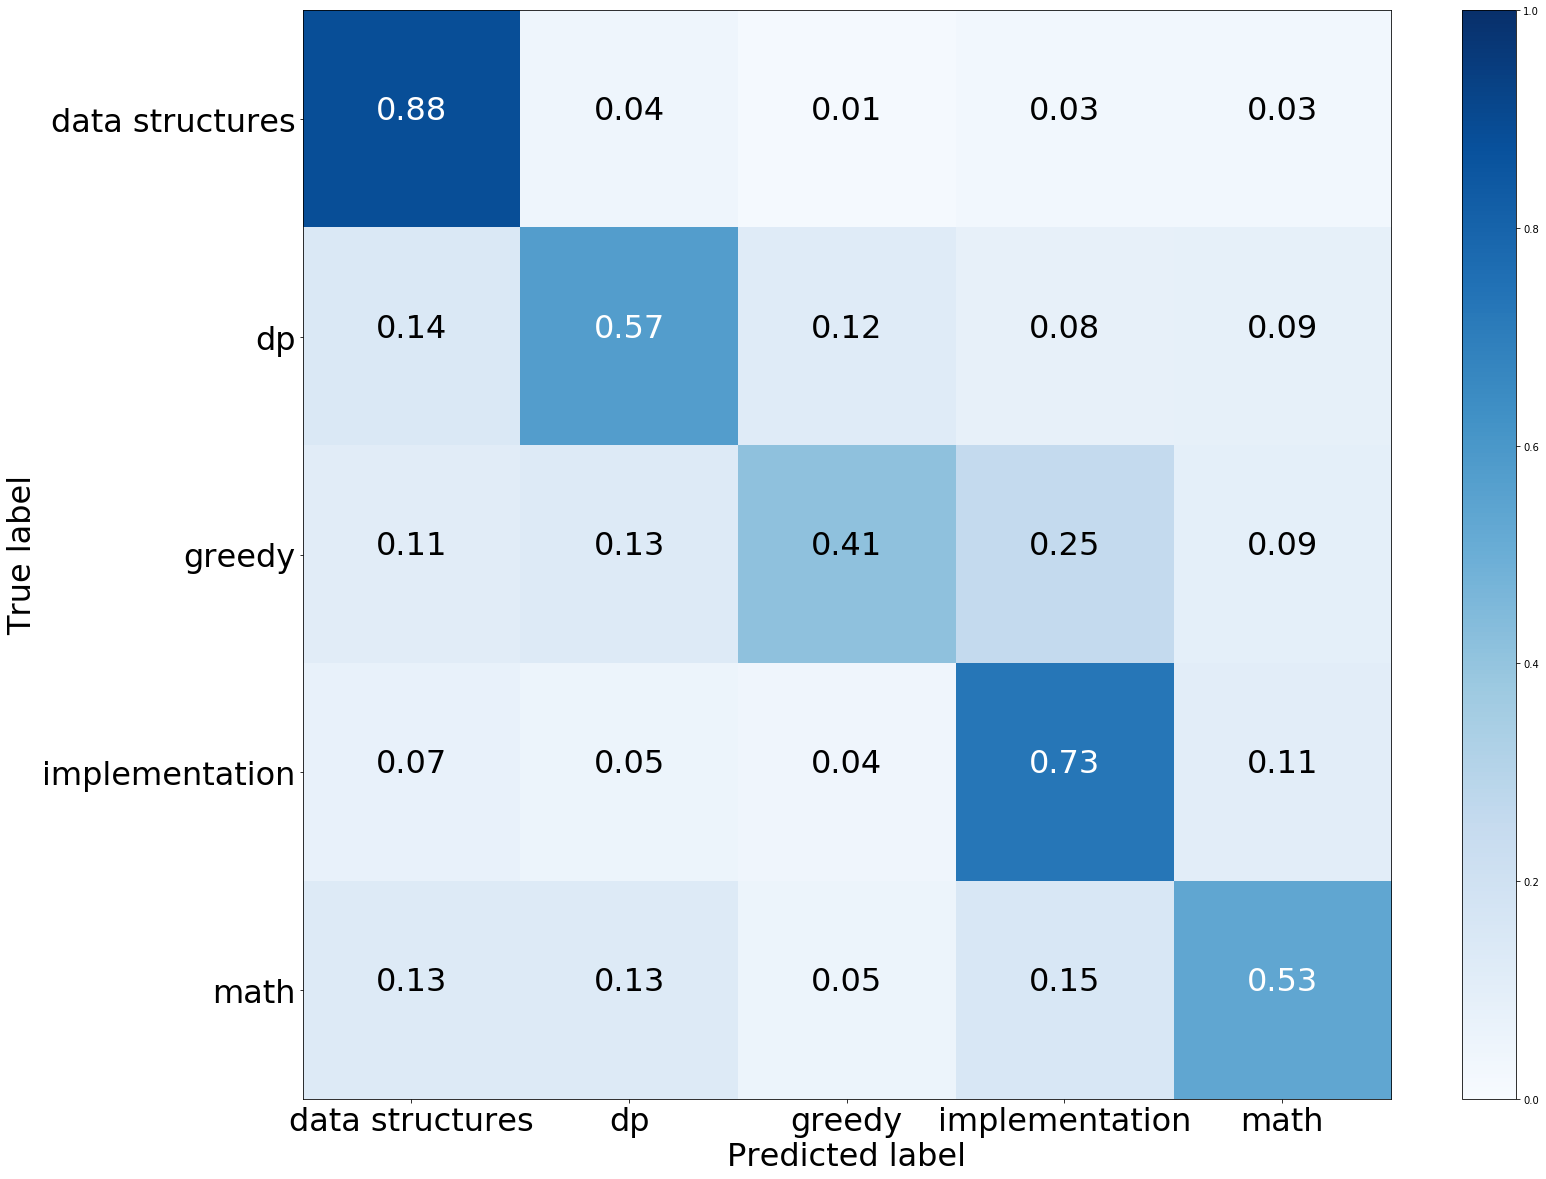

In [16]:
labels = ['data structures', 'dp', 'greedy', 'implementation', 'math']

print(classification_report(targs_txt, preds_txt, labels=labels))
print(accuracy_score(targs_txt, preds_txt))
print(f1_score(targs_txt, preds_txt, average='weighted'))
plot_confusion_matrix(targs_txt, preds_txt, labels)

### 10-class

In [18]:
trunner = TextRunner([None], top10s[0], top10s[1], 'top10s')
in_dim = len(trunner.alldata.tvectorizer.itos)
Xall, yall = trunner.dataset

Checkpoint reached: raw data cleaned.
multiclass classification.


In [19]:
runs = 5
out_dim = 10

preds_txt, targs_txt = [], []

for i in range(runs):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=i+42)
    
    outer_cv.get_n_splits(Xall, yall)
    for j, (nontest_i, test_i) in enumerate(outer_cv.split(Xall, yall)):
        X_train, y_train = Xall[nontest_i], yall[nontest_i]
        X_test, y_test = Xall[test_i], yall[test_i]
        
        textcnn = MWrapper(CNN_GloVe(in_dim, out_dim),
                               f'{i}_gl_cnntext10s_{j}')
        textcnn.model.apply(weights_init)

        dl_train = fd.DataLoader(SimpleDataset(X_train, y_train),
                                 batch_size=32, num_workers=2,
                                 pad_idx=1, transpose=False)
        dl_val = fd.DataLoader(SimpleDataset(X_test, y_test),
                               batch_size=32, num_workers=2,
                               pad_idx=1, transpose=False)
        modeldata = fs.ModelData(str(textcnn.path), dl_train, dl_val)
        learner = fl.Learner.from_model_data(textcnn.model,
                                             modeldata,
                                             opt_fn=Adam_lambda())
        learner.metrics = [fm.accuracy]
        learner.fit(5e-4, 10, best_save_name='best')
        
        dl_test = fd.DataLoader(SimpleDataset(X_test, y_test),
                                batch_size=32, num_workers=2,
                                pad_idx=1, transpose=False)
        learner.load('best')
        preds, targs = learner.predict_dl(dl_test)
        preds_txt += multi_to_text_out(preds, trunner.alldata.ovectorizer)
        targs_txt += multi_to_text_out(targs, trunner.alldata.ovectorizer)
        print(accuracy_score(targs_txt, preds_txt))

Note: Model directory for 0_gl_cnntext10s_0 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.083245   0.080036   0.353448  
    1      0.076339   0.071559   0.508621                   
    2      0.067618   0.068411   0.474138                   
    3      0.058575   0.068176   0.491379                   
    4      0.048487   0.067983   0.491379                   
    5      0.037653   0.06726    0.5                        
    6      0.027464   0.068754   0.517241                   
    7      0.019015   0.071066   0.508621                   
    8      0.013006   0.073785   0.482759                   
    9      0.010684   0.072701   0.474138                   

0.5172413793103449


epoch      trn_loss   val_loss   accuracy                   
    0      0.082409   0.080524   0.327586  
    1      0.075509   0.071428   0.482759                   
    2      0.066957   0.067052   0.482759                   
    3      0.057779   0.066909   0.508621                   
    4      0.047413   0.067431   0.5                        
    5      0.03646    0.06765    0.5                        
    6      0.026269   0.068513   0.5                        
    7      0.01775    0.069678   0.508621                   
    8      0.011405   0.071273   0.508621                   
    9      0.007522   0.073609   0.508621                    

0.5129310344827587


epoch      trn_loss   val_loss   accuracy                   
    0      0.08326    0.078197   0.362069  
    1      0.076719   0.070618   0.405172                   
    2      0.067897   0.067946   0.5                        
    3      0.059071   0.067053   0.534483                   
    4      0.049398   0.06624    0.525862                   
    5      0.038937   0.065784   0.551724                   
    6      0.02884    0.066262   0.551724                   
    7      0.020145   0.067362   0.534483                   
    8      0.01351    0.06947    0.560345                   
    9      0.009401   0.075647   0.491379                    

0.5287356321839081


epoch      trn_loss   val_loss   accuracy                   
    0      0.083205   0.079005   0.353448  
    1      0.076669   0.069899   0.491379                   
    2      0.067719   0.066278   0.517241                   
    3      0.058517   0.066458   0.534483                   
    4      0.048467   0.067359   0.508621                   
    5      0.037782   0.067436   0.525862                   
    6      0.027615   0.068898   0.525862                   
    7      0.019028   0.071005   0.508621                   
    8      0.012596   0.07376    0.474138                   
    9      0.008649   0.077554   0.439655                    

0.5301724137931034


epoch      trn_loss   val_loss   accuracy                   
    0      0.083202   0.083984   0.275862  
    1      0.075853   0.074597   0.396552                   
    2      0.06712    0.07314    0.431034                   
    3      0.058343   0.073691   0.431034                   
    4      0.048818   0.074388   0.439655                   
    5      0.03854    0.073601   0.439655                   
    6      0.02851    0.073885   0.474138                   
    7      0.019844   0.075088   0.474138                   
    8      0.013154   0.076342   0.448276                   
    9      0.008996   0.083452   0.465517                    

0.5189655172413793


epoch      trn_loss   val_loss   accuracy                   
    0      0.08328    0.076256   0.396552  
    1      0.07702    0.068182   0.482759                   
    2      0.068205   0.064443   0.551724                   
    3      0.059155   0.063671   0.560345                   
    4      0.049236   0.06327    0.586207                   
    5      0.038515   0.063101   0.560345                   
    6      0.028104   0.063787   0.551724                   
    7      0.019305   0.064902   0.543103                   
    8      0.012757   0.067221   0.551724                   
    9      0.00882    0.074911   0.439655                    

0.5301724137931034


epoch      trn_loss   val_loss   accuracy                   
    0      0.082575   0.083687   0.293103  
    1      0.075967   0.073153   0.422414                   
    2      0.067165   0.068775   0.465517                   
    3      0.057933   0.068331   0.474138                   
    4      0.047591   0.067324   0.5                        
    5      0.036633   0.067153   0.482759                   
    6      0.026382   0.067419   0.491379                   
    7      0.017852   0.067647   0.482759                   
    8      0.011691   0.068433   0.508621                   
    9      0.009965   0.072207   0.491379                    

0.5270935960591133


epoch      trn_loss   val_loss   accuracy                   
    0      0.083628   0.077116   0.396552  
    1      0.076567   0.069475   0.491379                   
    2      0.067456   0.066697   0.482759                   
    3      0.058458   0.065578   0.517241                   
    4      0.048606   0.066025   0.5                        
    5      0.038035   0.065753   0.5                        
    6      0.027861   0.066681   0.508621                   
    7      0.01923    0.06821    0.491379                   
    8      0.012831   0.070075   0.474138                   
    9      0.009148   0.069382   0.5                         

0.5258620689655172


epoch      trn_loss   val_loss   accuracy                   
    0      0.084301   0.077445   0.387931  
    1      0.077372   0.068834   0.508621                   
    2      0.068655   0.063112   0.551724                   
    3      0.059653   0.061515   0.577586                   
    4      0.049492   0.061286   0.586207                   
    5      0.038494   0.061064   0.594828                   
    6      0.02794    0.061586   0.594828                   
    7      0.019039   0.062736   0.637931                   
    8      0.012445   0.064253   0.637931                   
    9      0.008474   0.066953   0.637931                    

0.5383141762452107


epoch      trn_loss   val_loss   accuracy                   
    0      0.083032   0.080072   0.347826  
    1      0.076283   0.073134   0.373913                   
    2      0.067256   0.069001   0.452174                   
    3      0.058074   0.068314   0.452174                   
    4      0.048089   0.068986   0.46087                    
    5      0.037571   0.068483   0.46087                    
    6      0.027619   0.069806   0.469565                   
    7      0.019097   0.070812   0.469565                   
    8      0.012577   0.071663   0.46087                    
    9      0.008823   0.073898   0.443478                    

0.5314926660914582


epoch      trn_loss   val_loss   accuracy                   
    0      0.083086   0.079523   0.336207  
    1      0.076196   0.06842    0.508621                   
    2      0.067597   0.063443   0.534483                   
    3      0.058538   0.062683   0.551724                   
    4      0.048517   0.062639   0.551724                   
    5      0.037769   0.061867   0.586207                   
    6      0.027484   0.062902   0.560345                   
    7      0.018755   0.065251   0.543103                   
    8      0.012223   0.069181   0.534483                   
    9      0.008201   0.080018   0.5                         

0.5364705882352941


epoch      trn_loss   val_loss   accuracy                   
    0      0.0826     0.078508   0.353448  
    1      0.075687   0.069099   0.456897                   
    2      0.06717    0.064353   0.517241                   
    3      0.058126   0.062682   0.560345                   
    4      0.047922   0.062325   0.551724                   
    5      0.037169   0.062707   0.551724                   
    6      0.027037   0.063292   0.568966                   
    7      0.018459   0.064141   0.568966                   
    8      0.012015   0.065515   0.568966                   
    9      0.008075   0.067334   0.543103                    

0.5391804457225018


epoch      trn_loss   val_loss   accuracy                   
    0      0.083672   0.078078   0.37069   
    1      0.077399   0.068791   0.482759                   
    2      0.068905   0.062974   0.543103                   
    3      0.060158   0.061113   0.603448                   
    4      0.050414   0.061144   0.586207                   
    5      0.039916   0.060624   0.568966                   
    6      0.0297     0.060717   0.577586                   
    7      0.020804   0.061692   0.568966                   
    8      0.013981   0.065352   0.568966                   
    9      0.010042   0.072938   0.603448                   

0.544127405441274


epoch      trn_loss   val_loss   accuracy                   
    0      0.082893   0.078643   0.362069  
    1      0.076109   0.071763   0.465517                   
    2      0.067992   0.068432   0.517241                   
    3      0.059049   0.06734    0.534483                   
    4      0.049156   0.067752   0.543103                   
    5      0.038874   0.068965   0.508621                   
    6      0.029129   0.069421   0.508621                   
    7      0.020851   0.07023    0.5                        
    8      0.014752   0.070555   0.491379                   
    9      0.012482   0.078772   0.5                        

0.5440542205791744


epoch      trn_loss   val_loss   accuracy                   
    0      0.083118   0.078853   0.353448  
    1      0.076917   0.070091   0.474138                   
    2      0.067826   0.065515   0.491379                   
    3      0.058227   0.063583   0.525862                   
    4      0.047733   0.061293   0.534483                   
    5      0.036626   0.060983   0.560345                   
    6      0.026066   0.06176    0.586207                   
    7      0.017308   0.063054   0.612069                   
    8      0.01095    0.065518   0.62069                    
    9      0.00778    0.067048   0.568966                    

0.5491661874640598


epoch      trn_loss   val_loss   accuracy                   
    0      0.084294   0.074807   0.431034  
    1      0.077352   0.069088   0.508621                   
    2      0.068521   0.06692    0.517241                   
    3      0.059533   0.066625   0.517241                   
    4      0.049794   0.067509   0.491379                   
    5      0.039302   0.068178   0.482759                   
    6      0.029032   0.069572   0.482759                   
    7      0.020124   0.07143    0.456897                   
    8      0.013246   0.072863   0.431034                   
    9      0.00886    0.073452   0.482759                    

0.5471698113207547


epoch      trn_loss   val_loss   accuracy                   
    0      0.083205   0.079529   0.344828  
    1      0.076813   0.071939   0.448276                   
    2      0.067869   0.069088   0.474138                   
    3      0.058818   0.068522   0.525862                   
    4      0.049017   0.068954   0.508621                   
    5      0.038609   0.068985   0.482759                   
    6      0.028567   0.069439   0.5                        
    7      0.020078   0.070498   0.5                        
    8      0.01392    0.074222   0.474138                   
    9      0.011604   0.10467    0.318966                   

0.5459157787924911


epoch      trn_loss   val_loss   accuracy                   
    0      0.082831   0.084364   0.293103  
    1      0.076286   0.076674   0.37069                    
    2      0.067393   0.072156   0.422414                   
    3      0.057994   0.071332   0.456897                   
    4      0.047772   0.071353   0.439655                   
    5      0.036965   0.071483   0.448276                   
    6      0.026723   0.072392   0.456897                   
    7      0.018167   0.073853   0.474138                   
    8      0.011859   0.076404   0.448276                   
    9      0.008897   0.076828   0.439655                    

0.5419262098706277


epoch      trn_loss   val_loss   accuracy                   
    0      0.082524   0.079898   0.327586  
    1      0.075352   0.072064   0.439655                   
    2      0.066642   0.070429   0.448276                   
    3      0.057464   0.0708     0.474138                   
    4      0.047333   0.070849   0.5                        
    5      0.036543   0.070486   0.482759                   
    6      0.026395   0.070818   0.508621                   
    7      0.017892   0.07224    0.525862                   
    8      0.011583   0.074737   0.491379                   
    9      0.007687   0.077695   0.474138                    

0.5410803449841126


epoch      trn_loss   val_loss   accuracy                   
    0      0.082932   0.082205   0.321739  
    1      0.076411   0.074791   0.365217                   
    2      0.068067   0.070587   0.417391                   
    3      0.059545   0.069684   0.478261                   
    4      0.049989   0.069173   0.495652                   
    5      0.039425   0.068273   0.521739                   
    6      0.02895    0.068433   0.521739                   
    7      0.019966   0.069839   0.53913                    
    8      0.013234   0.072921   0.530435                   
    9      0.009218   0.077694   0.452174                    

0.5409836065573771


epoch      trn_loss   val_loss   accuracy                   
    0      0.083353   0.076575   0.396552  
    1      0.077013   0.069161   0.5                        
    2      0.068241   0.065619   0.560345                   
    3      0.059448   0.065034   0.568966                   
    4      0.0498     0.065299   0.560345                   
    5      0.039363   0.065107   0.586207                   
    6      0.029119   0.065454   0.612069                   
    7      0.020185   0.066716   0.586207                   
    8      0.013257   0.067691   0.577586                   
    9      0.008552   0.068913   0.560345                    

0.5443714050944947


epoch      trn_loss   val_loss   accuracy                   
    0      0.083481   0.083624   0.301724  
    1      0.077122   0.075852   0.37931                    
    2      0.068563   0.06997    0.474138                   
    3      0.059447   0.068937   0.456897                   
    4      0.049338   0.068458   0.431034                   
    5      0.038346   0.067987   0.482759                   
    6      0.027781   0.06879    0.5                        
    7      0.018952   0.070136   0.508621                   
    8      0.012549   0.072713   0.5                        
    9      0.008938   0.076873   0.456897                    

0.5427450980392157


epoch      trn_loss   val_loss   accuracy                   
    0      0.082851   0.084895   0.258621  
    1      0.07655    0.076475   0.336207                   
    2      0.06809    0.070318   0.474138                   
    3      0.059276   0.067989   0.431034                   
    4      0.049597   0.067723   0.439655                   
    5      0.039002   0.066976   0.448276                   
    6      0.028638   0.067516   0.474138                   
    7      0.019814   0.068535   0.482759                   
    8      0.01308    0.06987    0.491379                   
    9      0.008675   0.071574   0.474138                    

0.540510127531883


epoch      trn_loss   val_loss   accuracy                   
    0      0.083386   0.077854   0.387931  
    1      0.07758    0.070153   0.465517                   
    2      0.068877   0.067011   0.517241                   
    3      0.059567   0.068037   0.543103                   
    4      0.049579   0.0687     0.543103                   
    5      0.038836   0.0679     0.551724                   
    6      0.028365   0.06812    0.560345                   
    7      0.019421   0.069495   0.534483                   
    8      0.012669   0.070013   0.543103                   
    9      0.008501   0.071633   0.525862                    

0.5413371675053918


epoch      trn_loss   val_loss   accuracy                   
    0      0.083302   0.081906   0.318966  
    1      0.076563   0.073256   0.422414                   
    2      0.067792   0.069097   0.482759                   
    3      0.058704   0.067833   0.508621                   
    4      0.048734   0.068038   0.543103                   
    5      0.038161   0.068674   0.517241                   
    6      0.028008   0.069731   0.482759                   
    7      0.01937    0.071105   0.448276                   
    8      0.012744   0.071975   0.456897                   
    9      0.008294   0.072793   0.439655                    

0.5414078674948241


epoch      trn_loss   val_loss   accuracy                   
    0      0.083036   0.080873   0.327586  
    1      0.075716   0.07211    0.413793                   
    2      0.067262   0.068499   0.448276                   
    3      0.058532   0.067012   0.525862                   
    4      0.048745   0.066757   0.534483                   
    5      0.038338   0.06669    0.543103                   
    6      0.028449   0.067676   0.534483                   
    7      0.020038   0.069827   0.5                        
    8      0.013906   0.071635   0.508621                   
    9      0.011412   0.073041   0.5                        

0.5414731254147312


epoch      trn_loss   val_loss   accuracy                   
    0      0.083301   0.078433   0.387931  
    1      0.076937   0.072563   0.439655                   
    2      0.068075   0.068075   0.482759                   
    3      0.05895    0.06842    0.491379                   
    4      0.049138   0.068972   0.5                        
    5      0.038573   0.068389   0.517241                   
    6      0.02829    0.069443   0.525862                   
    7      0.019475   0.070762   0.534483                   
    8      0.012751   0.072725   0.517241                   
    9      0.008354   0.075125   0.525862                    

0.5412140575079872


epoch      trn_loss   val_loss   accuracy                   
    0      0.083057   0.077645   0.387931  
    1      0.076826   0.070923   0.448276                   
    2      0.068096   0.066878   0.534483                   
    3      0.058919   0.067511   0.543103                   
    4      0.048905   0.067384   0.560345                   
    5      0.038231   0.066713   0.560345                   
    6      0.028002   0.068025   0.560345                   
    7      0.019277   0.069201   0.551724                   
    8      0.012647   0.071338   0.517241                   
    9      0.008856   0.071432   0.551724                    

0.541897720271103


epoch      trn_loss   val_loss   accuracy                   
    0      0.083223   0.076493   0.37931   
    1      0.076667   0.068475   0.525862                   
    2      0.068377   0.064635   0.560345                   
    3      0.059364   0.064932   0.551724                   
    4      0.049276   0.065729   0.525862                   
    5      0.038445   0.066386   0.525862                   
    6      0.028131   0.068081   0.5                        
    7      0.019369   0.069513   0.508621                   
    8      0.012787   0.070674   0.508621                   
    9      0.009058   0.078846   0.456897                    

0.5425342058298632


epoch      trn_loss   val_loss   accuracy                   
    0      0.082585   0.078176   0.347826  
    1      0.075942   0.069975   0.46087                    
    2      0.067536   0.066703   0.53913                    
    3      0.058592   0.066083   0.582609                   
    4      0.048616   0.066082   0.626087                   
    5      0.037989   0.06566    0.626087                   
    6      0.027776   0.066125   0.582609                   
    7      0.018996   0.06738    0.565217                   
    8      0.012327   0.070208   0.565217                   
    9      0.008341   0.075966   0.530435                    

0.545297670405522


epoch      trn_loss   val_loss   accuracy                   
    0      0.083567   0.076152   0.396552  
    1      0.076834   0.067208   0.534483                   
    2      0.067728   0.064776   0.577586                   
    3      0.058436   0.064051   0.551724                   
    4      0.048234   0.063631   0.568966                   
    5      0.037307   0.062303   0.568966                   
    6      0.026917   0.063445   0.534483                   
    7      0.018192   0.065996   0.534483                   
    8      0.011756   0.070103   0.543103                   
    9      0.008077   0.075382   0.517241                    

0.5463401057612023


epoch      trn_loss   val_loss   accuracy                   
    0      0.082862   0.077614   0.37931   
    1      0.07627    0.06837    0.482759                   
    2      0.067825   0.063187   0.525862                   
    3      0.058935   0.061086   0.551724                   
    4      0.048853   0.060802   0.568966                   
    5      0.037902   0.060457   0.594828                   
    6      0.027468   0.061756   0.551724                   
    7      0.018684   0.064222   0.560345                   
    8      0.012251   0.067668   0.543103                   
    9      0.009408   0.081811   0.422414                    

0.54785656511189


epoch      trn_loss   val_loss   accuracy                   
    0      0.083114   0.082119   0.327586  
    1      0.076457   0.074366   0.387931                   
    2      0.067828   0.070294   0.456897                   
    3      0.059019   0.069911   0.491379                   
    4      0.049346   0.070729   0.508621                   
    5      0.038987   0.071875   0.482759                   
    6      0.029023   0.072992   0.482759                   
    7      0.020499   0.074682   0.465517                   
    8      0.014017   0.078378   0.448276                   
    9      0.010132   0.084141   0.37931                    

0.5466666666666666


epoch      trn_loss   val_loss   accuracy                   
    0      0.083308   0.081483   0.310345  
    1      0.076682   0.072094   0.413793                   
    2      0.06809    0.066607   0.517241                   
    3      0.059441   0.065745   0.543103                   
    4      0.049818   0.066051   0.543103                   
    5      0.039268   0.066359   0.534483                   
    6      0.028906   0.066931   0.534483                   
    7      0.020077   0.067929   0.517241                   
    8      0.013462   0.069118   0.525862                   
    9      0.009487   0.069631   0.534483                    

0.5465617863486425


epoch      trn_loss   val_loss   accuracy                   
    0      0.08292    0.077396   0.37069   
    1      0.076543   0.067498   0.5                        
    2      0.067888   0.061941   0.560345                   
    3      0.058837   0.060981   0.603448                   
    4      0.048825   0.061246   0.594828                   
    5      0.038032   0.061103   0.594828                   
    6      0.027721   0.062268   0.577586                   
    7      0.018982   0.0637     0.577586                   
    8      0.012421   0.065451   0.577586                   
    9      0.008251   0.068374   0.594828                    

0.5481883164900172


epoch      trn_loss   val_loss   accuracy                   
    0      0.083153   0.082248   0.336207  
    1      0.077231   0.072048   0.413793                   
    2      0.06867    0.068132   0.543103                   
    3      0.059585   0.068151   0.491379                   
    4      0.049345   0.067743   0.5                        
    5      0.038228   0.067175   0.517241                   
    6      0.027749   0.068423   0.5                        
    7      0.019047   0.069759   0.517241                   
    8      0.01274    0.073207   0.508621                   
    9      0.009722   0.087342   0.456897                    

0.5480469686077163


epoch      trn_loss   val_loss   accuracy                   
    0      0.08316    0.079276   0.344828  
    1      0.076416   0.072669   0.422414                   
    2      0.067484   0.069924   0.474138                   
    3      0.058384   0.068609   0.482759                   
    4      0.048444   0.068328   0.482759                   
    5      0.037848   0.067836   0.517241                   
    6      0.027729   0.068036   0.551724                   
    7      0.019248   0.071205   0.534483                   
    8      0.013473   0.080698   0.465517                   
    9      0.015364   0.071517   0.5                        

0.5481464210771742


epoch      trn_loss   val_loss   accuracy                   
    0      0.083175   0.078392   0.37069   
    1      0.076234   0.070669   0.482759                   
    2      0.067641   0.067784   0.5                        
    3      0.058761   0.067557   0.543103                   
    4      0.048855   0.067677   0.534483                   
    5      0.038235   0.067473   0.543103                   
    6      0.028083   0.068378   0.543103                   
    7      0.019448   0.068931   0.543103                   
    8      0.013      0.068689   0.543103                   
    9      0.01027    0.07526    0.551724                   

0.5482406356413166


epoch      trn_loss   val_loss   accuracy                   
    0      0.083512   0.078596   0.37931   
    1      0.077219   0.073209   0.405172                   
    2      0.068112   0.069572   0.465517                   
    3      0.058486   0.069422   0.491379                   
    4      0.048268   0.06943    0.508621                   
    5      0.037538   0.069594   0.517241                   
    6      0.027374   0.071107   0.525862                   
    7      0.018757   0.07321    0.525862                   
    8      0.012229   0.075451   0.517241                   
    9      0.008053   0.074393   0.525862                    

0.5476664454766644


epoch      trn_loss   val_loss   accuracy                   
    0      0.082705   0.085478   0.278261  
    1      0.076414   0.07538    0.373913                   
    2      0.067663   0.070032   0.46087                    
    3      0.058683   0.068961   0.469565                   
    4      0.048639   0.069218   0.46087                    
    5      0.037765   0.069496   0.469565                   
    6      0.027354   0.070465   0.478261                   
    7      0.018696   0.072353   0.478261                   
    8      0.012372   0.074512   0.46087                    
    9      0.008736   0.073641   0.478261                    

0.5459447799827437


epoch      trn_loss   val_loss   accuracy                   
    0      0.084011   0.076843   0.387931  
    1      0.076831   0.068494   0.534483                   
    2      0.068078   0.064411   0.534483                   
    3      0.059366   0.063356   0.543103                   
    4      0.049792   0.063344   0.560345                   
    5      0.039415   0.063859   0.560345                   
    6      0.029282   0.064125   0.577586                   
    7      0.02066    0.064043   0.568966                   
    8      0.014401   0.063796   0.560345                   
    9      0.011777   0.071977   0.560345                   

0.5467171717171717


epoch      trn_loss   val_loss   accuracy                   
    0      0.08316    0.076832   0.405172  
    1      0.077104   0.07154    0.422414                   
    2      0.068186   0.06723    0.482759                   
    3      0.058801   0.067498   0.491379                   
    4      0.048898   0.068066   0.5                        
    5      0.038354   0.06803    0.534483                   
    6      0.028183   0.068875   0.543103                   
    7      0.019418   0.070414   0.534483                   
    8      0.012655   0.072811   0.5                        
    9      0.008173   0.076444   0.456897                    

0.5466310599835661


epoch      trn_loss   val_loss   accuracy                   
    0      0.083405   0.082279   0.310345  
    1      0.076955   0.073731   0.405172                   
    2      0.067906   0.069968   0.456897                   
    3      0.058849   0.069087   0.5                        
    4      0.048941   0.067772   0.491379                   
    5      0.038314   0.067795   0.5                        
    6      0.02803    0.068079   0.482759                   
    7      0.019156   0.068699   0.482759                   
    8      0.01255    0.069439   0.474138                   
    9      0.008907   0.07697    0.456897                    

0.545545746388443


epoch      trn_loss   val_loss   accuracy                   
    0      0.083229   0.083081   0.284483  
    1      0.076797   0.07293    0.422414                   
    2      0.068391   0.067504   0.491379                   
    3      0.059457   0.065644   0.534483                   
    4      0.049456   0.06569    0.517241                   
    5      0.038689   0.065363   0.534483                   
    6      0.028325   0.066699   0.534483                   
    7      0.019475   0.069144   0.551724                   
    8      0.012807   0.073034   0.517241                   
    9      0.008773   0.07867    0.5                         

0.5456862745098039


epoch      trn_loss   val_loss   accuracy                   
    0      0.082972   0.079683   0.344828  
    1      0.076742   0.069127   0.482759                   
    2      0.067854   0.065033   0.534483                   
    3      0.058637   0.06504    0.551724                   
    4      0.048442   0.064712   0.568966                   
    5      0.037635   0.06462    0.568966                   
    6      0.027417   0.065576   0.560345                   
    7      0.018769   0.067063   0.543103                   
    8      0.012248   0.068716   0.534483                   
    9      0.008282   0.070993   0.534483                    

0.5462039877300614


epoch      trn_loss   val_loss   accuracy                   
    0      0.083797   0.077649   0.362069  
    1      0.077468   0.070445   0.431034                   
    2      0.069074   0.064982   0.543103                   
    3      0.060543   0.063094   0.560345                   
    4      0.051217   0.062932   0.568966                   
    5      0.0409     0.063244   0.551724                   
    6      0.030422   0.063223   0.560345                   
    7      0.021188   0.064839   0.543103                   
    8      0.013991   0.066645   0.551724                   
    9      0.009083   0.067977   0.525862                    

0.5466991747936985


epoch      trn_loss   val_loss   accuracy                   
    0      0.083763   0.077893   0.413793  
    1      0.077356   0.070285   0.5                        
    2      0.068479   0.067246   0.491379                   
    3      0.05943    0.067563   0.525862                   
    4      0.049679   0.068659   0.525862                   
    5      0.039242   0.069072   0.525862                   
    6      0.029072   0.070533   0.508621                   
    7      0.02032    0.072842   0.525862                   
    8      0.013699   0.075334   0.508621                   
    9      0.009715   0.082869   0.474138                    

0.5462555066079295


epoch      trn_loss   val_loss   accuracy                   
    0      0.082815   0.077971   0.362069  
    1      0.075498   0.069196   0.465517                   
    2      0.067097   0.065707   0.508621                   
    3      0.058392   0.064865   0.508621                   
    4      0.048643   0.065373   0.508621                   
    5      0.038054   0.065601   0.517241                   
    6      0.027953   0.067004   0.491379                   
    7      0.019445   0.068742   0.482759                   
    8      0.013069   0.071797   0.422414                   
    9      0.009739   0.078186   0.413793                    

0.5456506110711719


epoch      trn_loss   val_loss   accuracy                   
    0      0.082352   0.083903   0.284483  
    1      0.075819   0.075612   0.344828                   
    2      0.067416   0.0718     0.405172                   
    3      0.058622   0.070804   0.439655                   
    4      0.048662   0.071033   0.456897                   
    5      0.037853   0.070846   0.431034                   
    6      0.027522   0.071341   0.431034                   
    7      0.018792   0.072192   0.431034                   
    8      0.012255   0.074034   0.448276                   
    9      0.008237   0.078171   0.456897                    

0.543838028169014


epoch      trn_loss   val_loss   accuracy                   
    0      0.082792   0.08033    0.33913   
    1      0.075855   0.073424   0.408696                   
    2      0.067344   0.070331   0.469565                   
    3      0.058551   0.069506   0.478261                   
    4      0.04898    0.069204   0.504348                   
    5      0.038486   0.068663   0.486957                   
    6      0.028272   0.069344   0.495652                   
    7      0.019573   0.071195   0.504348                   
    8      0.013039   0.074099   0.486957                   
    9      0.009118   0.078668   0.469565                    

0.5430543572044866


In [21]:
# pickle.dump([preds_txt, targs_txt], open('data/results/cnn-glove_10s.pkl', 'wb'))
preds_txt, targs_txt = pickle.load(open('data/results/cnn-glove_10s.pkl', 'rb'))

                         precision    recall  f1-score   support

            brute force       0.10      0.01      0.02       325
constructive algorithms       0.33      0.23      0.27       320
        data structures       0.61      0.68      0.65       550
                     dp       0.55      0.46      0.50       720
        dfs and similar       0.62      0.17      0.26       180
               geometry       0.56      0.68      0.61       245
                 greedy       0.37      0.23      0.29       605
         implementation       0.63      0.84      0.72      2025
                   math       0.36      0.44      0.40       660
                strings       0.41      0.24      0.30       165

            avg / total       0.50      0.54      0.51      5795

0.5430543572044866
0.5079713799886553
Normalized confusion matrix
[[0.00923 0.05231 0.05231 0.09538 0.      0.00308 0.08    0.52923 0.17538 0.00308]
 [0.00937 0.225   0.0625  0.05625 0.00937 0.05    0.09688 0.275   0.

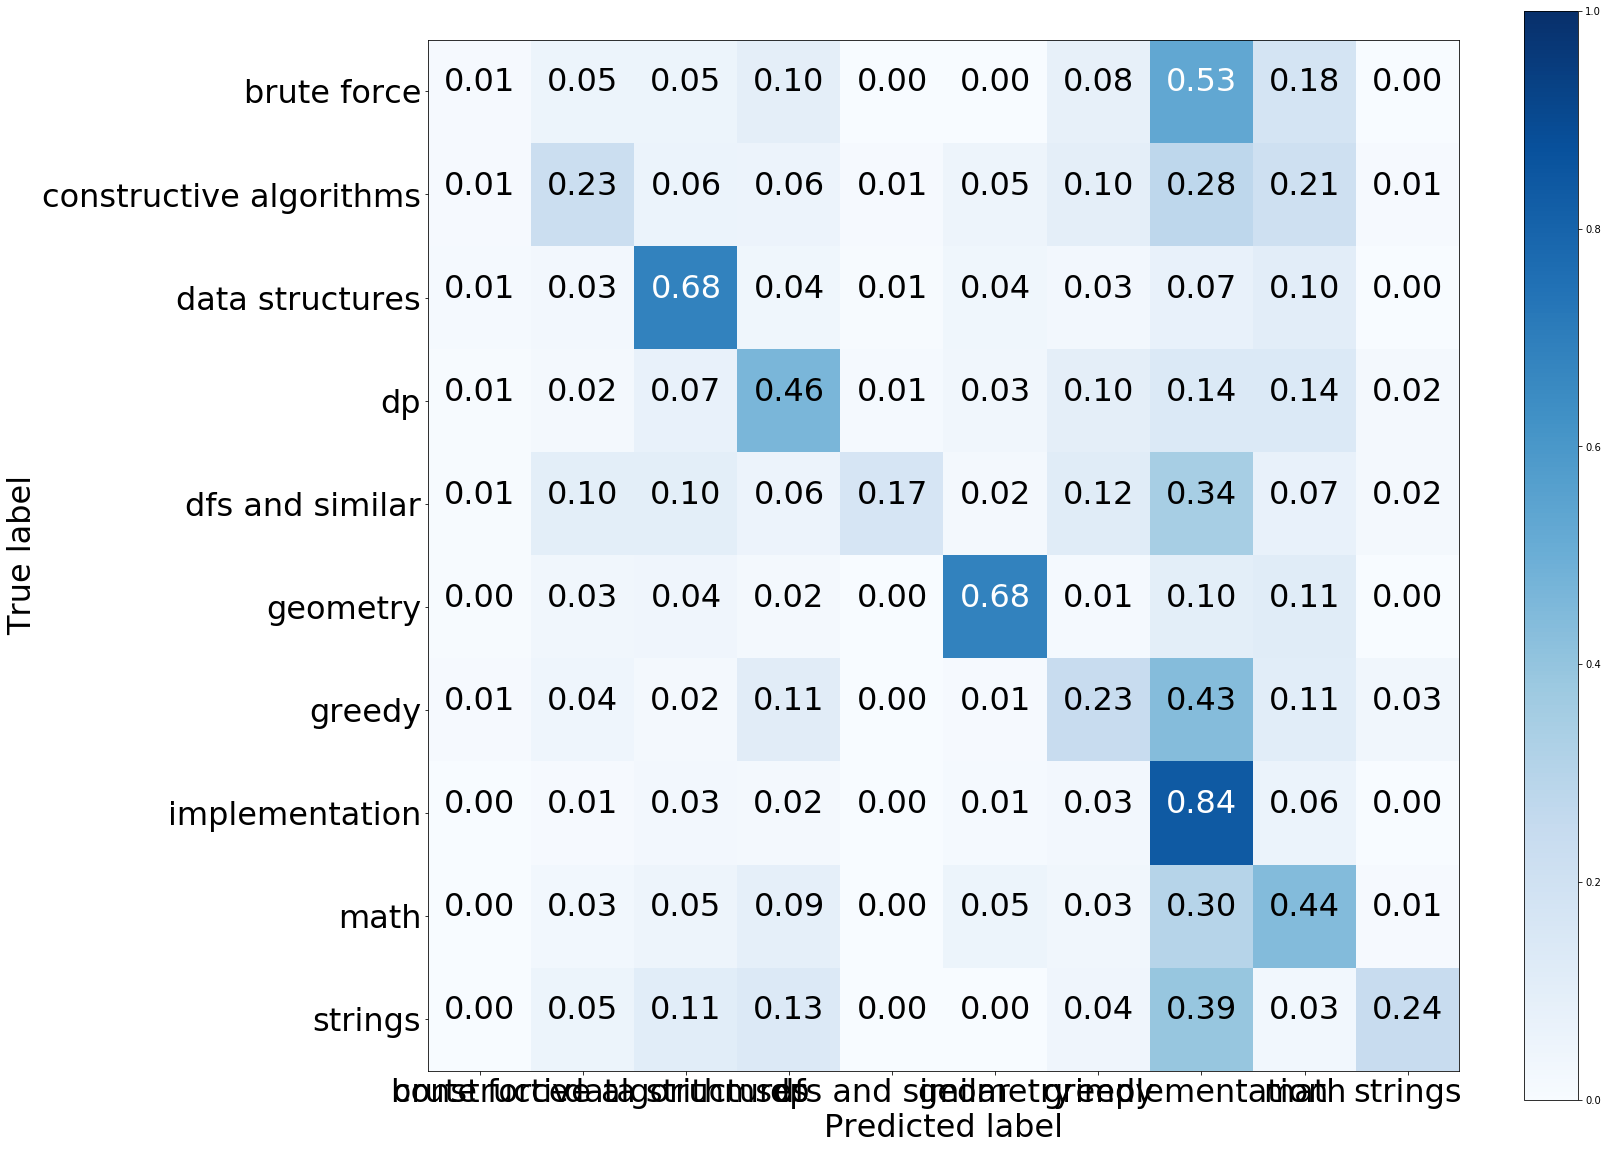

In [22]:
labels = ['brute force', 'constructive algorithms', 'data structures',
          'dp', 'dfs and similar', 'geometry', 'greedy',
          'implementation', 'math', 'strings']

print(classification_report(targs_txt, preds_txt, labels=labels))
print(accuracy_score(targs_txt, preds_txt))
print(f1_score(targs_txt, preds_txt, average='weighted'))
plot_confusion_matrix(targs_txt, preds_txt, labels)